# Intercomparison Campaigns - Compare Sounding Data

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the usability of data from intercomparison campaigns. 

    Author: U. Voggenberger
    Date: 09.2020
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2020

In [1]:
import pandas
import numpy as np
import datetime
import glob
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cdsapi, zipfile, os, time

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)#

## Accessing data directly via eua - h5py:

We will check the sounding data and compare different sondes, which were all mounted onto the same balloon. <br>
It's not necessary to select the data with the help of 'ListProfiles.xls' - a file for mapping the data of the different sondes to one ascent. <br>
Opening all available data and searching for the matching report_id would be possible too, but slower. <br> <br>

We will display temperature and pressure over time and a combined plot. <br>
Every ascent should be plotted propperly and we will see, if all units are added correctly.


### Requesting all data from intercomparison campaign 03 via Wildcard:
    
    ['0-20100-0-003*']

In [3]:
# requesting and downloading the data:
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature"],
                   'overwrite': [True],
                   'statid': ['0-20100-0-003*'],
                   'period': '19000101/20201231',
                   'optional': ['sonde_type'],
                   'format': 'csv'                   
               })

if True:
    # Start Download
    r.download(target='download.zip')
    # Check file size
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    # Unzip the Data Stream
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data/3")
    print(z.namelist())
    z.extractall(path='./example_data/3')
    z.close()
    os.remove('download.zip')

2021-06-21 13:01:17,578 INFO Welcome to the CDS
2021-06-21 13:01:17,580 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-21 13:01:17,752 INFO Request is completed
2021-06-21 13:01:17,755 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1624273252.567158-10793-14-28550bbc-8e52-44ac-8edc-bbfc9b7a1b42.zip to download.zip (73.7K)
2021-06-21 13:01:17,871 INFO Download rate 637.9K/s


Unzipping retrieved files: to ./exampla_data/3
['temperature.csv']


In [9]:
pandas.set_option('display.width',200, 'display.max_rows',50)
data = pandas.read_csv('example_data/3/temperature.csv', index_col=0)
data.time = pandas.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data.time = (data.time - pandas.Timestamp("1900-01-01")) // pandas.Timedelta('1s')

data

,lat,lon,plev,report_id,sonde_type,ta,time,trajectory_label,ta_units,plev_units,statindex
obs_id,,,,,,,,,,,
0,50.880278,4.419167,19400.0,0-20100-0-00301-001,"Z41,Z4_",210.25,1730792820,nnnnnnnnnnnnnnnnnnn,K,Pa,0
1,50.880278,4.419167,20600.0,0-20100-0-00301-001,"Z41,Z4_",208.95,1730792760,nnnnnnnnnnnnnnnnnnn,K,Pa,0
2,50.880278,4.419167,21800.0,0-20100-0-00301-001,"Z41,Z4_",210.05,1730792700,nnnnnnnnnnnnnnnnnnn,K,Pa,0
3,50.880278,4.419167,23200.0,0-20100-0-00301-001,"Z41,Z4_",212.15,1730792640,nnnnnnnnnnnnnnnnnnn,K,Pa,0
4,50.880278,4.419167,24500.0,0-20100-0-00301-001,"Z41,Z4_",214.55,1730792580,nnnnnnnnnnnnnnnnnnn,K,Pa,0
...,...,...,...,...,...,...,...,...,...,...,...
5888,50.880278,4.419167,82800.0,0-20100-0-00305-029,UBD,271.45,1731879720,nnnnnnnnnnnnnnnnnnn,K,Pa,4
5889,50.880278,4.419167,86300.0,0-20100-0-00305-029,UBD,268.75,1731879660,nnnnnnnnnnnnnnnnnnn,K,Pa,4
5890,50.880278,4.419167,90000.0,0-20100-0-00305-029,UBD,271.55,1731879600,nnnnnnnnnnnnnnnnnnn,K,Pa,4


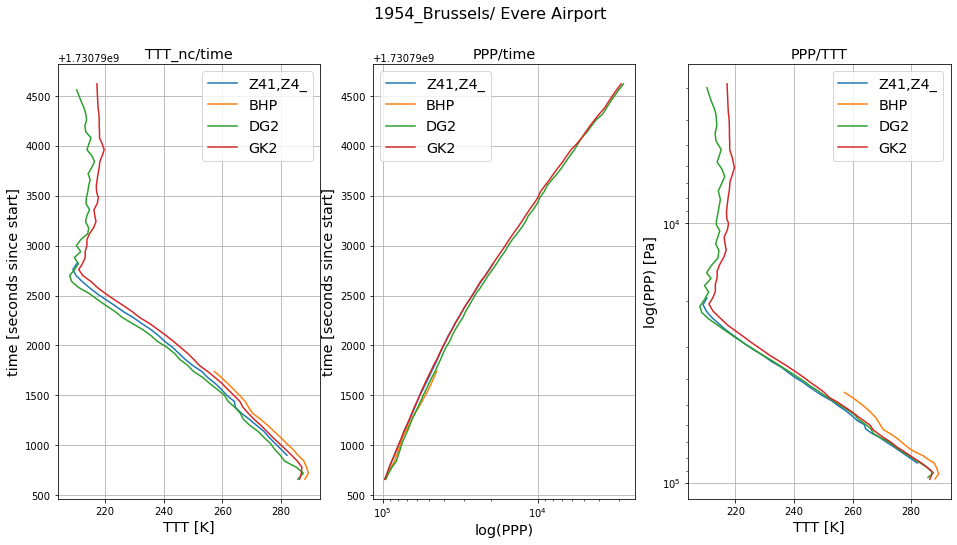

----


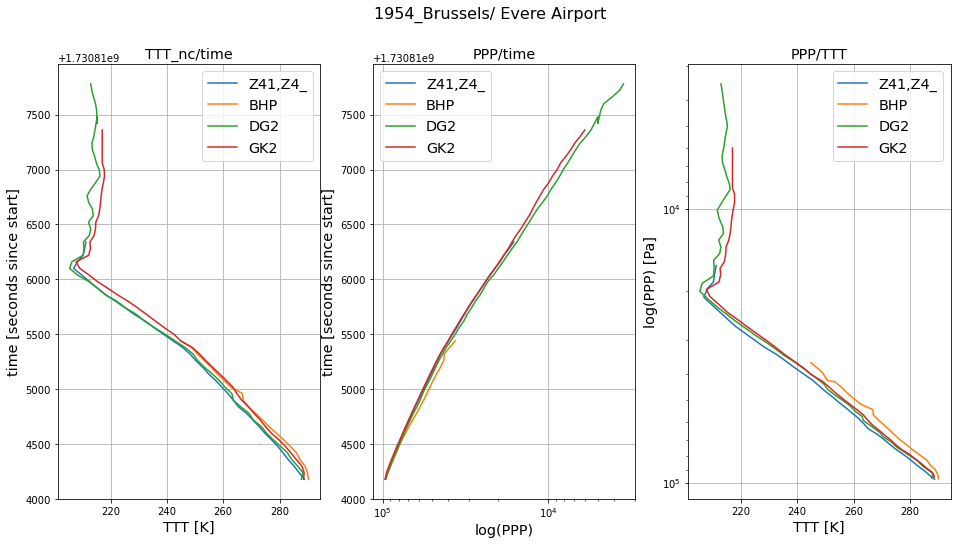

----


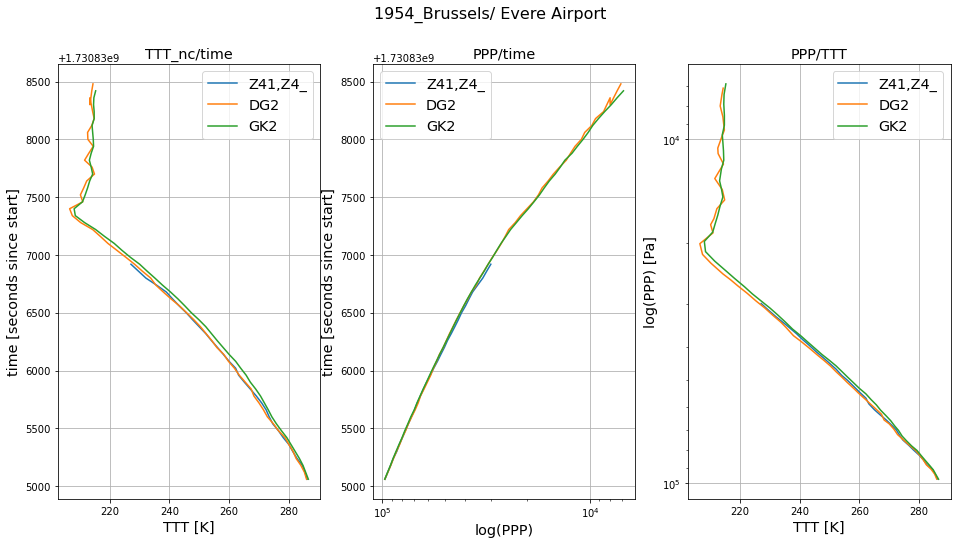

----


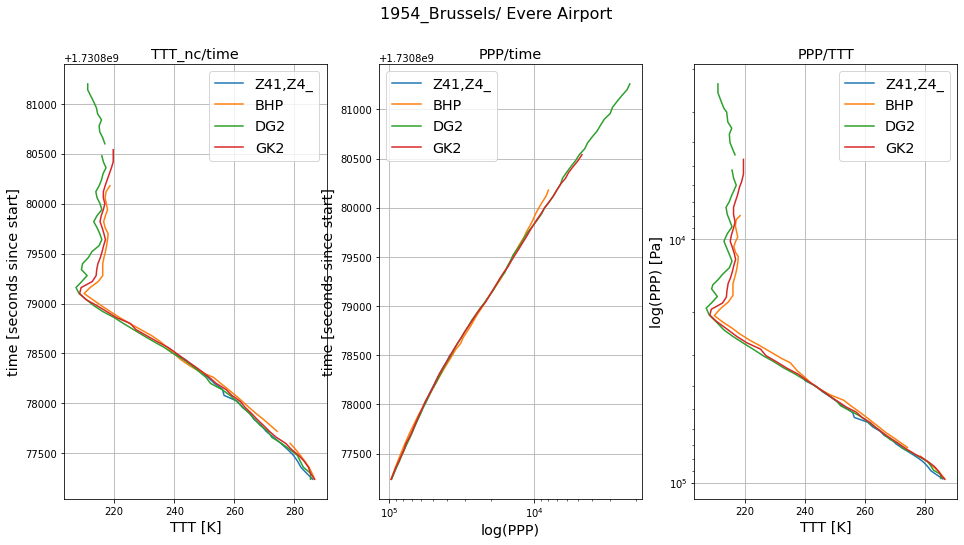

----


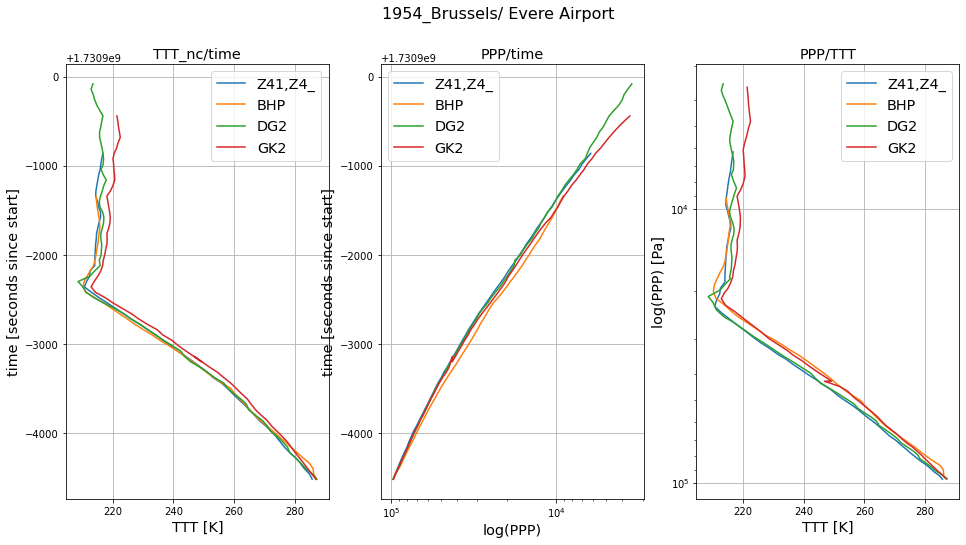

----


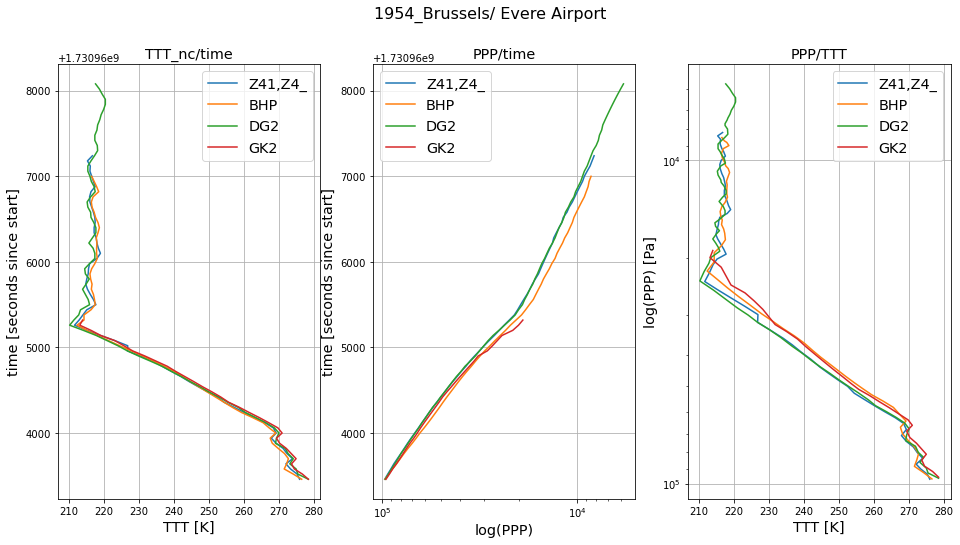

----


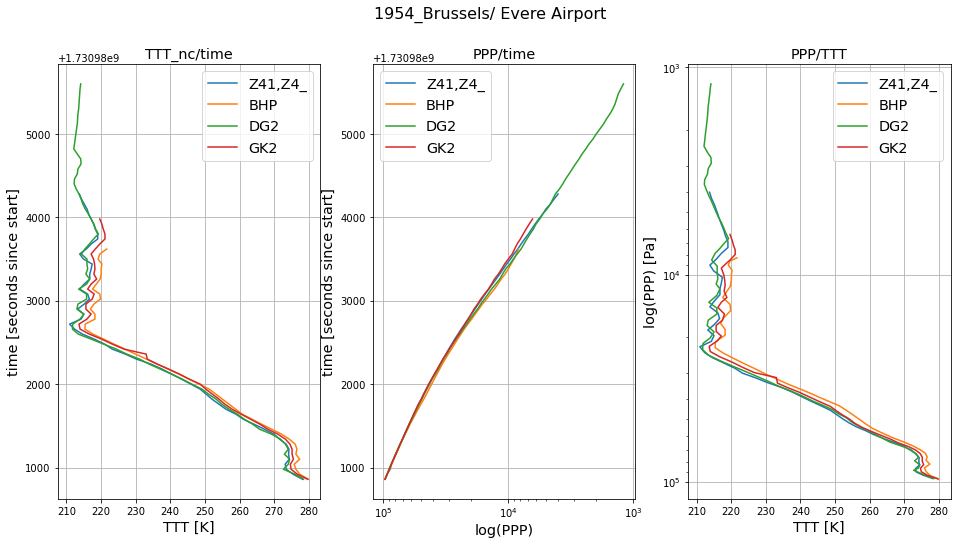

----


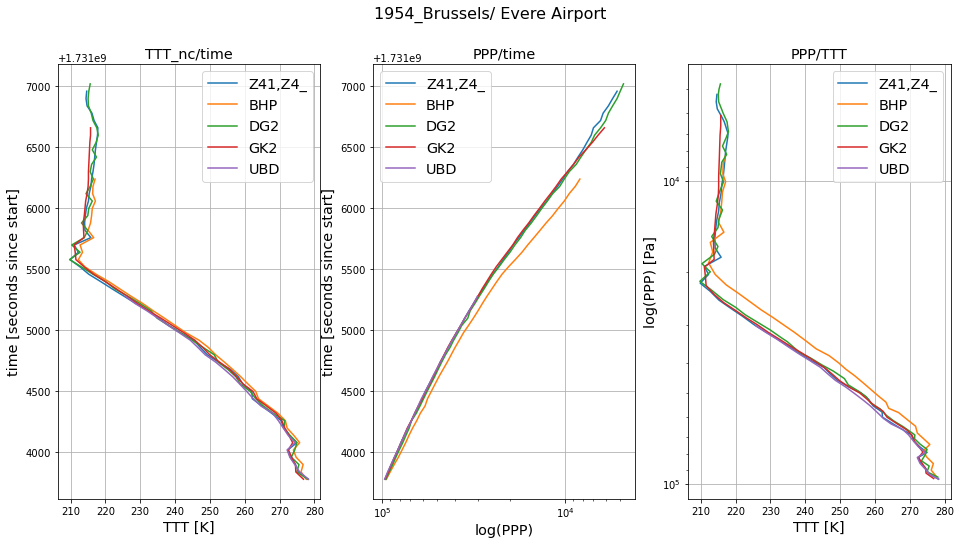

----


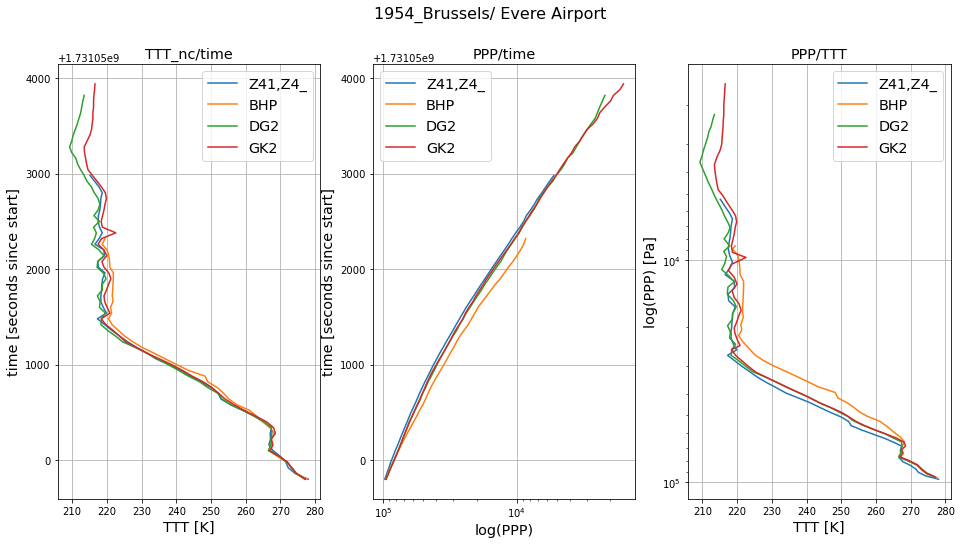

----


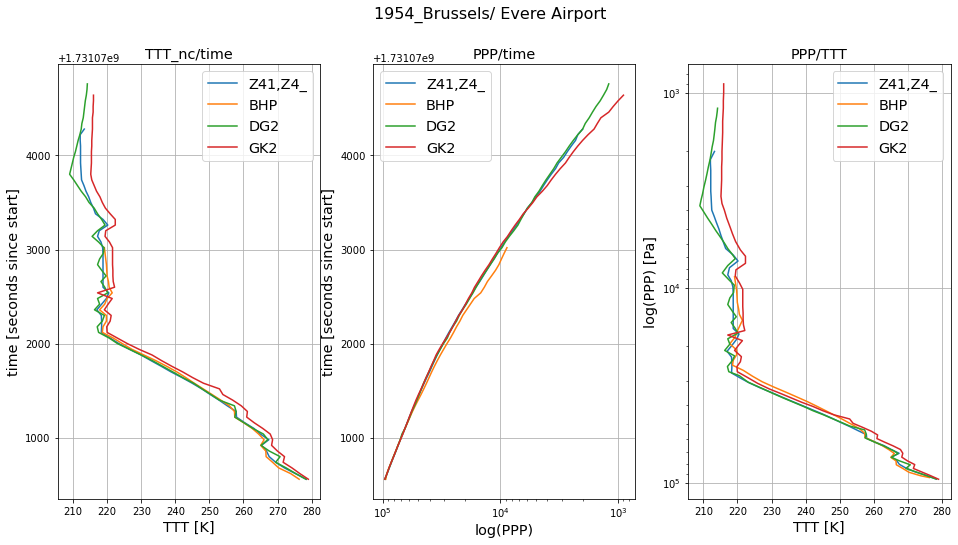

----


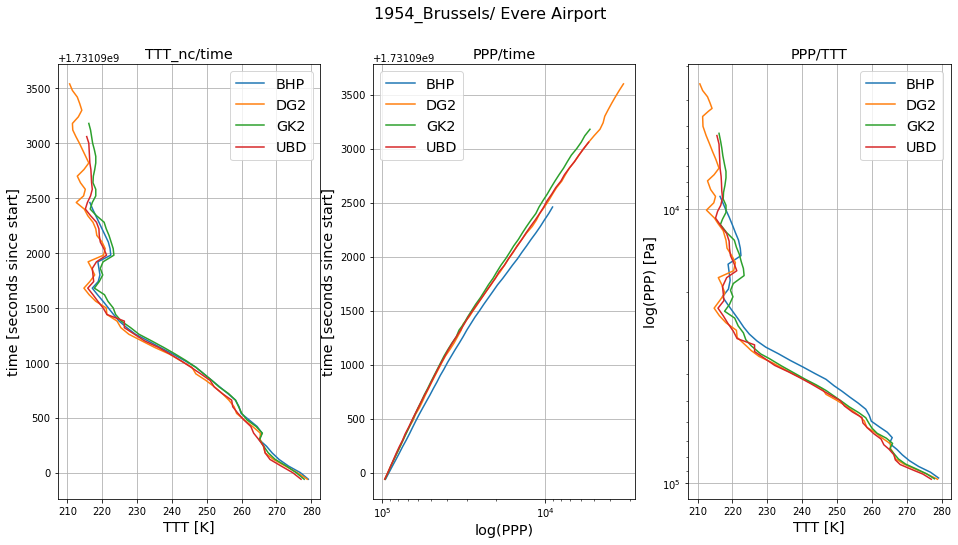

----


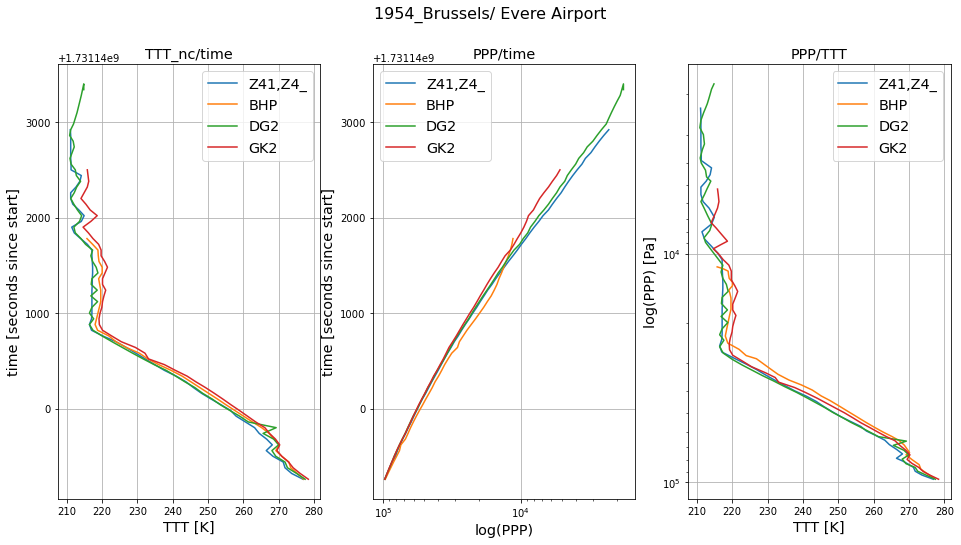

----


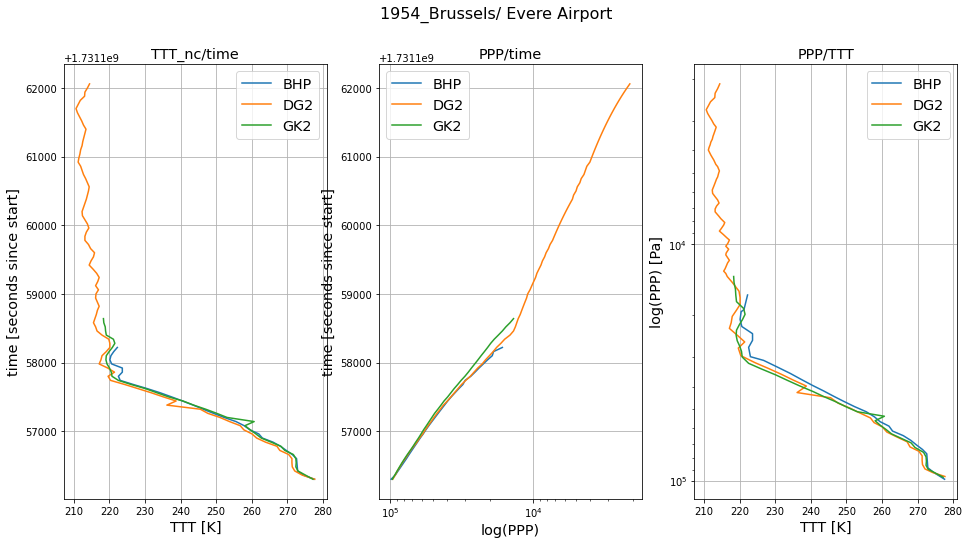

----


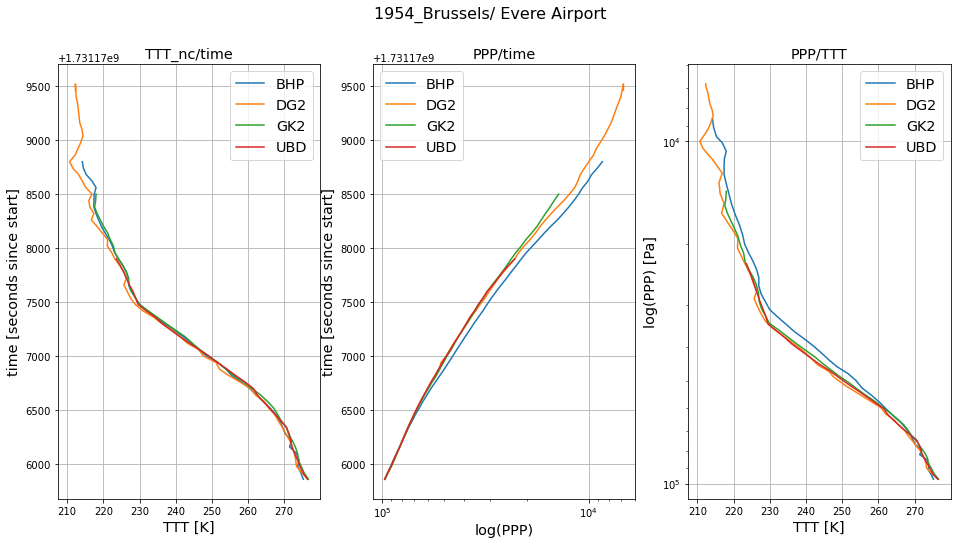

----


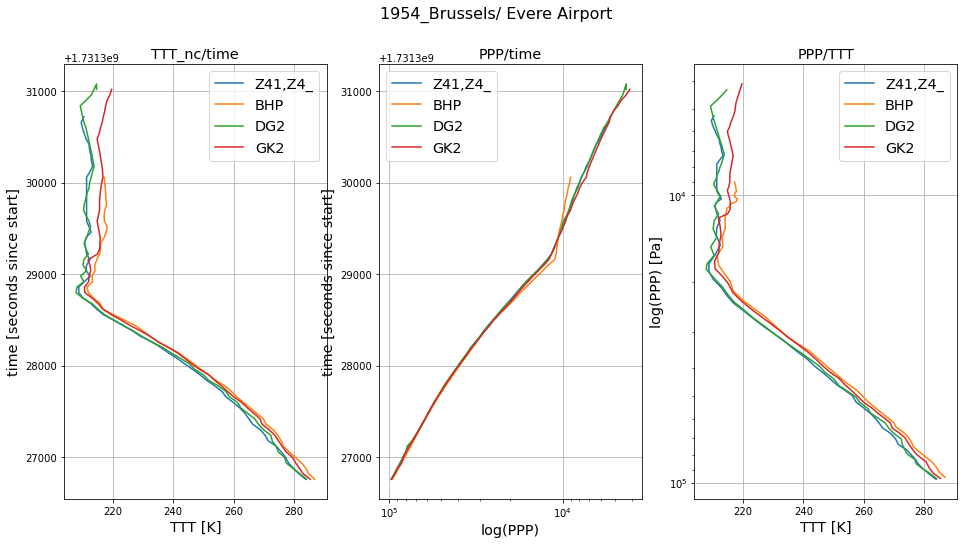

----


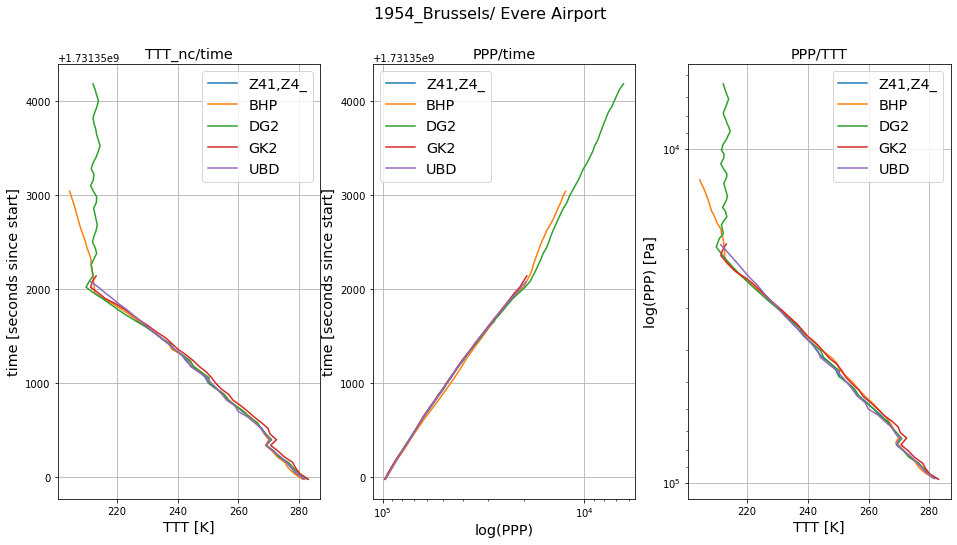

----


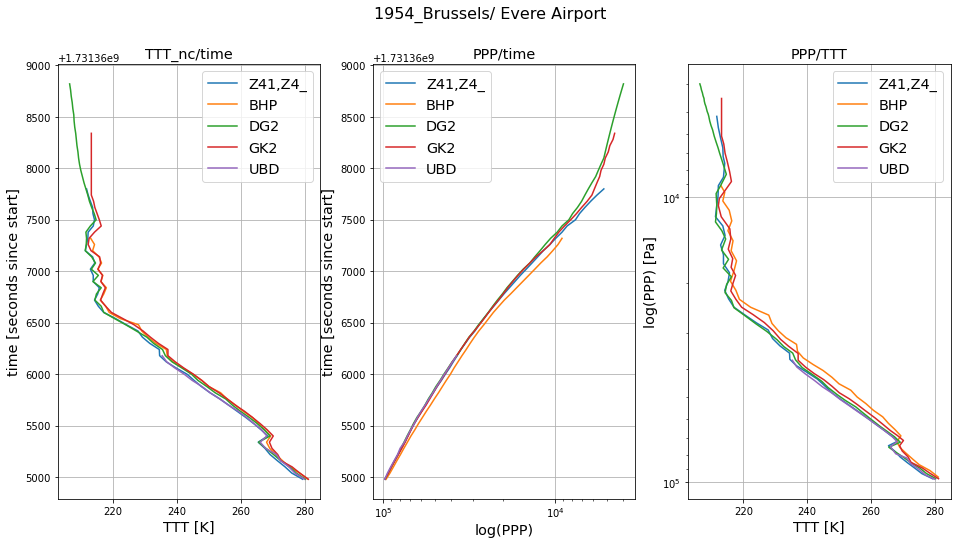

----


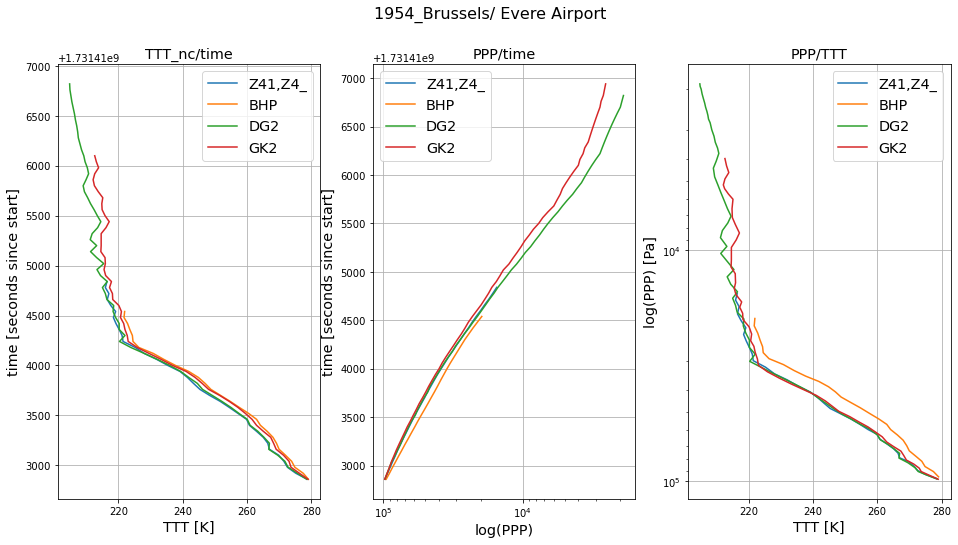

----


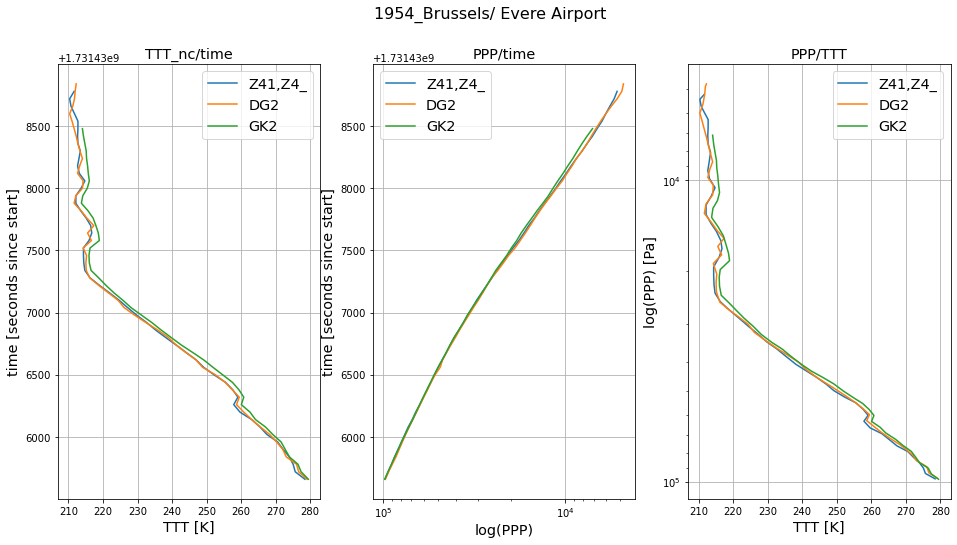

----


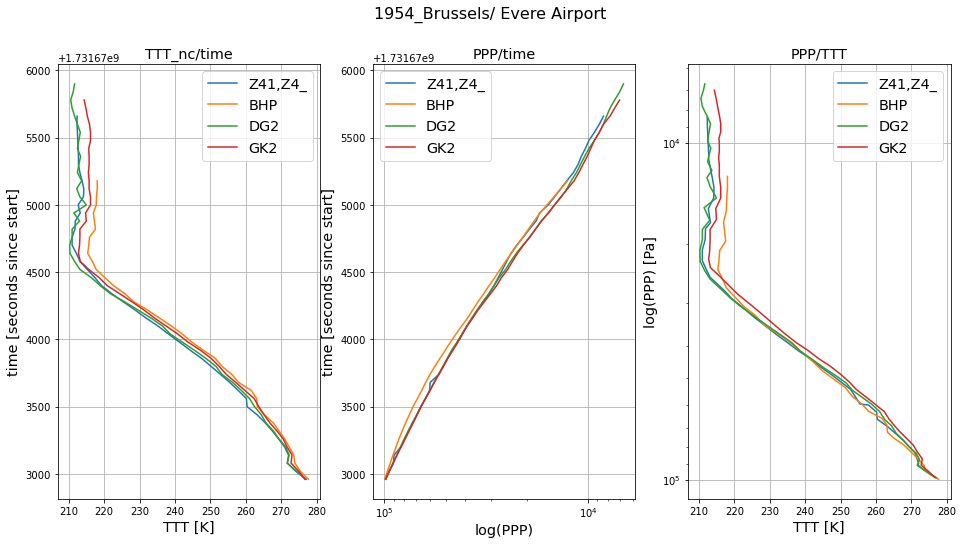

----


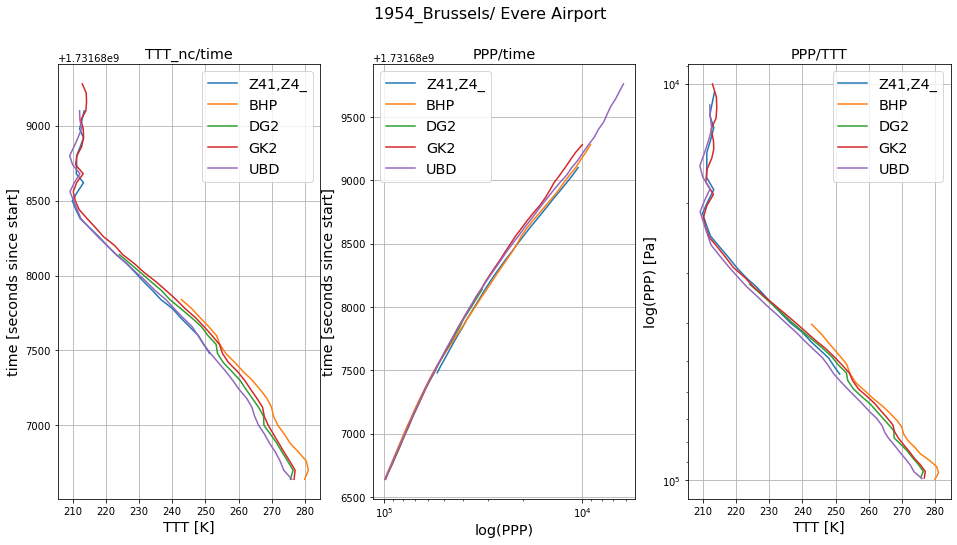

----


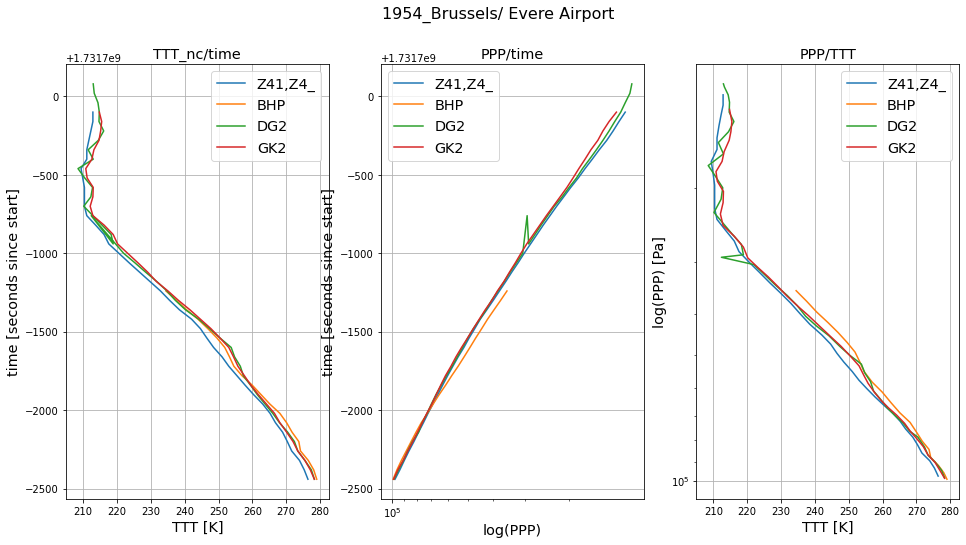

----


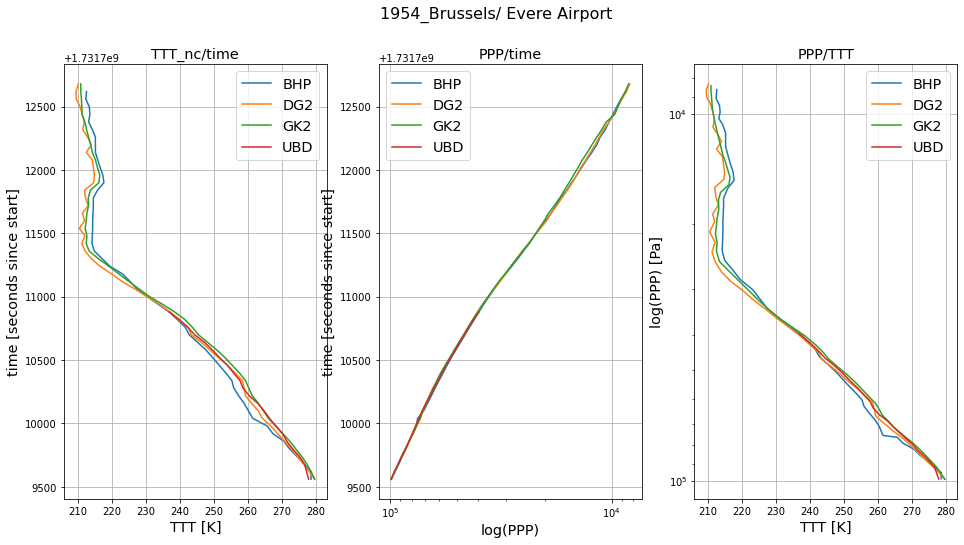

----


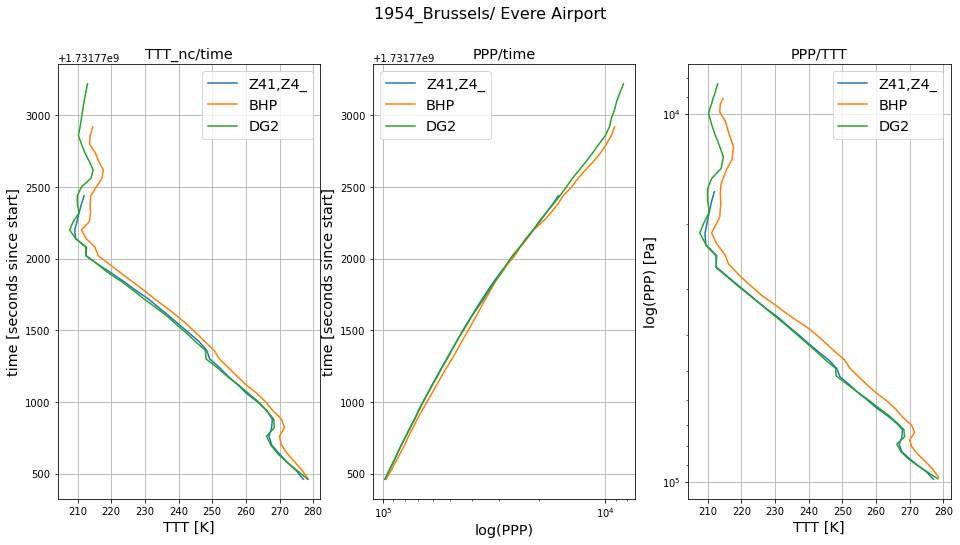

----


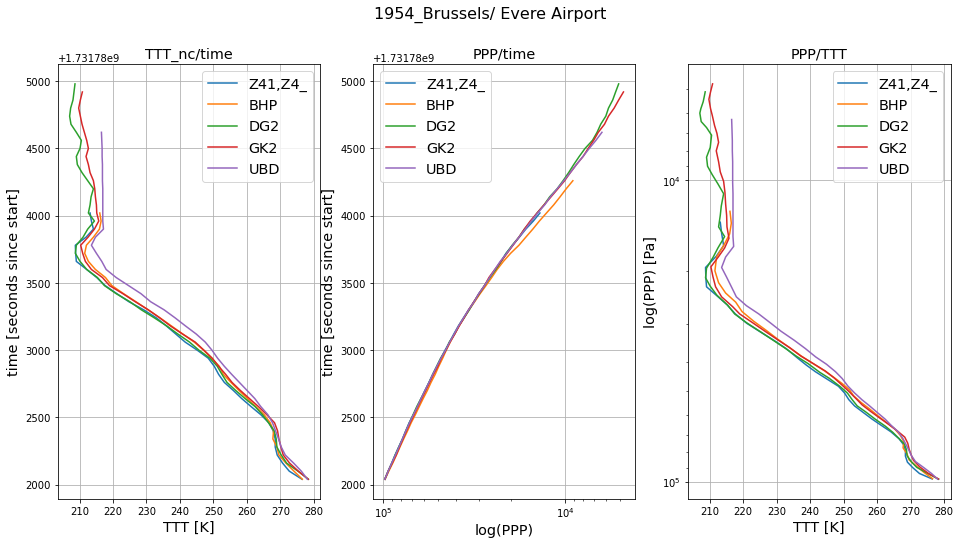

----


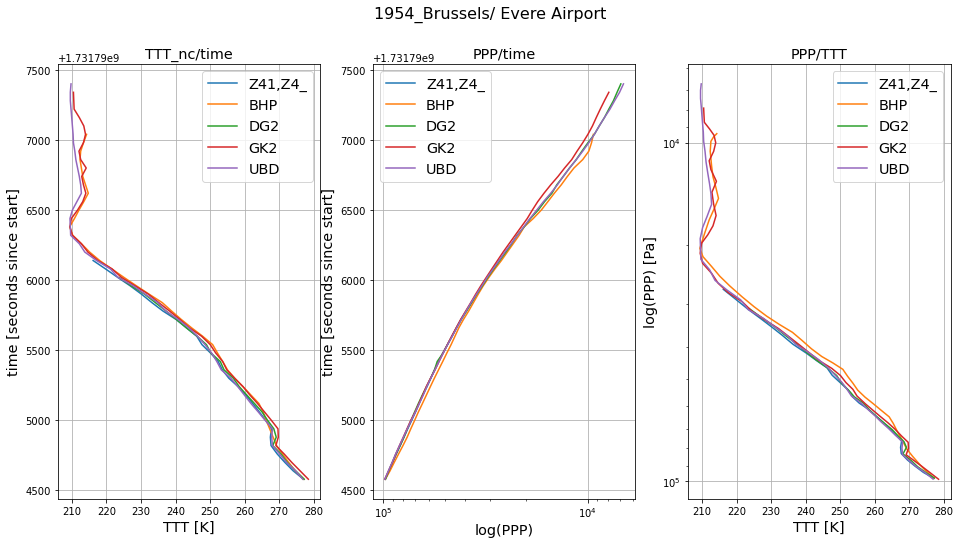

----


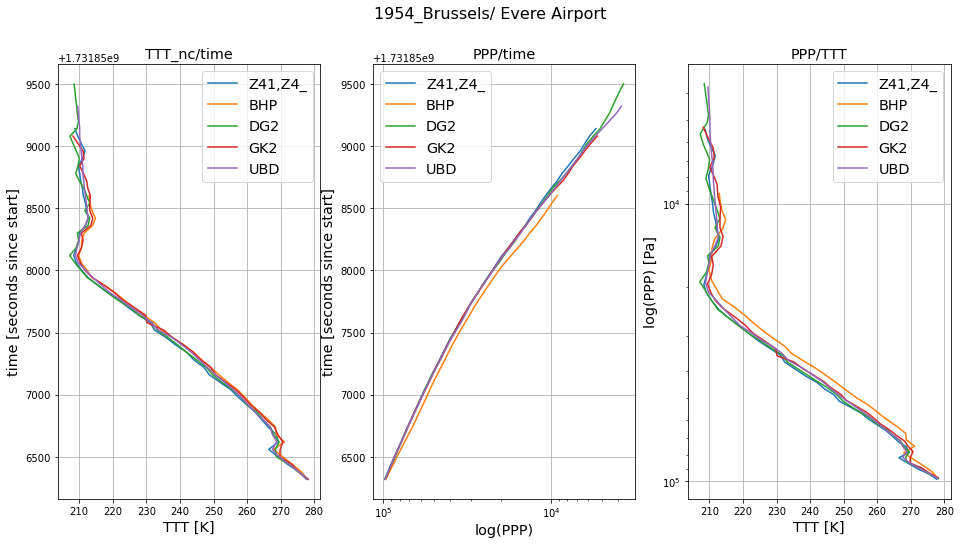

----


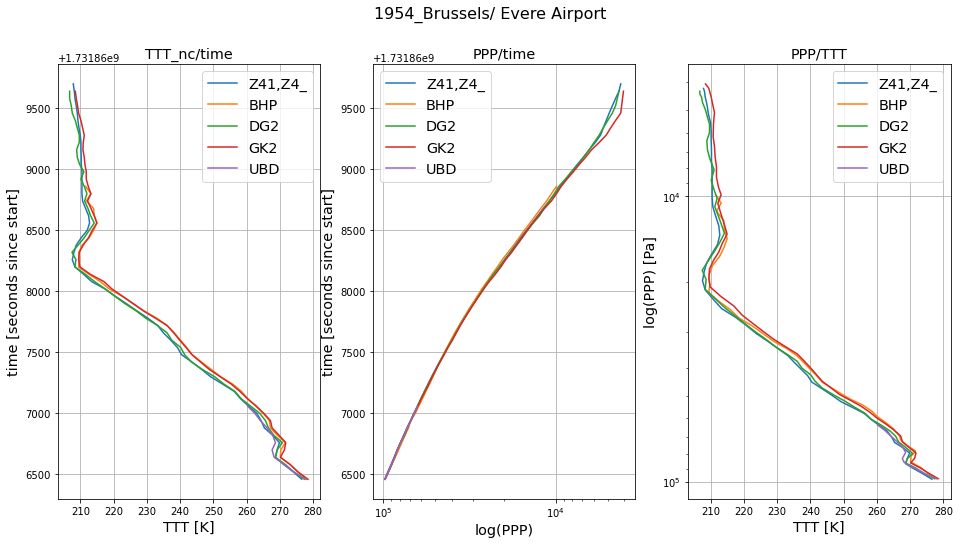

----


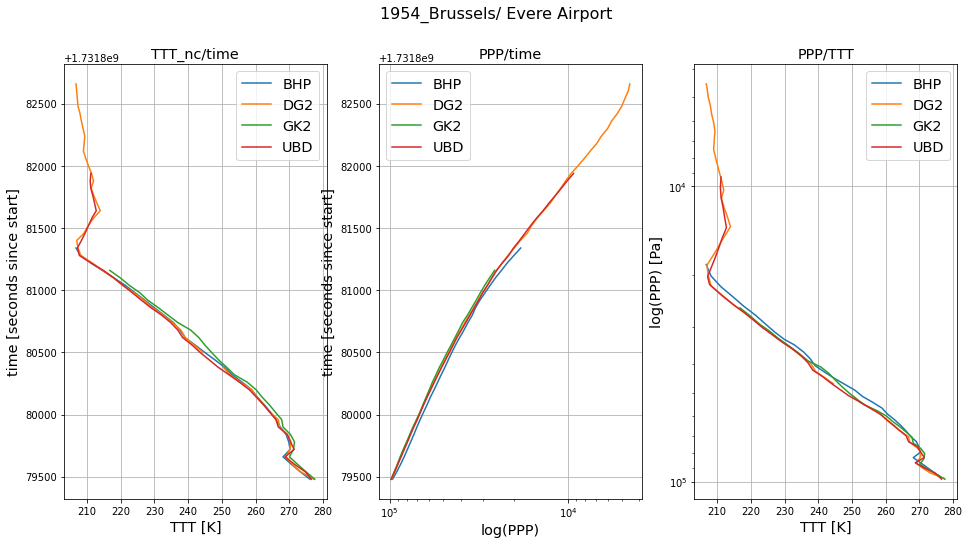

----


In [13]:
comp = 'COMP003'

all_tl = []
for i in data.report_id.drop_duplicates(): all_tl.append(i[-3:])
for i in np.unique(all_tl):
    x = data[data.report_id.str[-3:] == i]
    temp = []
    pres = []
    time = []
    sondlist = []
    for k in x.sonde_type.drop_duplicates():
        xx = x[x.sonde_type == k]
        xx.reset_index(drop=True)
        temp.append(np.array(xx.ta))
        time.append(np.array(xx.time))
        pres.append(np.array(xx.plev))
        sondlist.append(xx.iloc[0].sonde_type)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#     fig.tight_layout()
#     -
    for i in range(len(temp)):
        ax1.plot(temp[i], time[i])
    ax1.set(xlabel ='TTT [K]', ylabel='time [seconds since start]', title='TTT_nc/time')
    ax1.legend(sondlist, loc='best')
    ax1.grid()
#     -
    for i in range(len(pres)):
        ax2.semilogx(pres[i], time[i])
    ax2.set(xlabel='log(PPP)', ylabel ='time [seconds since start]', title='PPP/time')
    ax2.invert_xaxis()
    ax2.legend(sondlist, loc='best')
    ax2.grid()
#     -
    for i in range(len(temp)):
        ax3.semilogy(temp[i], pres[i])
    ax3.set(xlabel ='TTT [K]', ylabel='log(PPP) [Pa]', title='PPP/TTT')
    ax3.invert_yaxis()
    ax3.legend(sondlist, loc='best')
    ax3.grid()
#     -
    picname = str(i)
    fig.suptitle(picname, fontsize=16)
    plt.show()
#     fig.savefig(picname +'.png')
    plt.close(fig)
    print('----')